In [1]:
import matplotlib.animation as animation
from matplotlib.animation import ArtistAnimation, FuncAnimation
import numpy as np
import pandas as pd
import os
import gc
from matplotlib import pyplot as plt
import seaborn as sns
import cv2

In [2]:
dnbr = np.load('../../cloud_control_data_dnbr.npz')['dnbr']
labs = (dnbr>0.66).astype(int)
water_mask = np.load('../../water_mask_based_on_ndvi_565.npy')
water_mask = np.expand_dims(water_mask, 2)
for i in range(len(labs)):
    labs[i,:][water_mask==1] = 0
    
dnbr = dnbr.astype('float64')
dnbr_medians = np.zeros(len(dnbr))
for i in range(len(dnbr)):
    dnbr_medians[i] = np.median(dnbr[i,:,:,0]).round(2)
 

In [3]:
'''
imgs = np.load('../../../cloud_control_data.npz')['imgs']
smooth = 1e-5
b08 = imgs[:,:,:,7:8] 
b04 = imgs[:,:,:,3:4]
b12 = imgs[:,:,:,11:12]
ndvi= (b08-b04+smooth)/(b08+b04+smooth)
nbr = (b08-b12+smooth)/(b08+b12+smooth)
'''

In [57]:
bigquery_res = pd.read_csv('/Volumes/My Passport for Mac/sentinel_2_53HPA/bigquery_results_s.csv', index_col=0)
bigquery_res['sensing_time'] = pd.to_datetime(bigquery_res['sensing_time'])
bigquery_res = bigquery_res.reset_index(drop=True)
subset_idx = np.array(bigquery_res[bigquery_res['cloud_cover']<75].index)
bigquery_res_s = bigquery_res.iloc[subset_idx,:]
bigquery_res_s = bigquery_res_s.reset_index(drop=True)


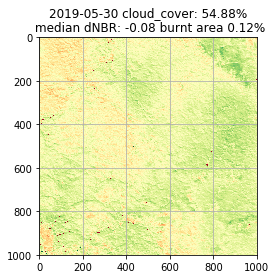

In [39]:
fig = plt.figure()


##### idx 0-35
i=-1
MAX=36

##### idx 36-71
i=35
MAX=72

#### idx 72-107
i=71
MAX=108


im = plt.imshow(dnbr[i,:,:,0], cmap='RdYlGn_r', vmin=-1, vmax=1, animated=True)
plt.grid(True)
thres = 0.66
title = plt.title(f"{bigquery_res_s['sensing_time'].dt.date.map(lambda t:str(t))[i+1]} cloud_cover: {bigquery_res_s['cloud_cover'][i+1].round(2)}%\n median dNBR: {dnbr_medians[i]} burnt area {(100*(labs[i,:,:,0].sum())/(1000*1000)).round(2)}%")

def updatefig(*args):
    global i
    if (i<=MAX):
        i += 1
    else:
        pass
    im.set_array(dnbr[i-2,:,:,0])
    title.set_text(f"{bigquery_res_s['sensing_time'].dt.date.map(lambda t:str(t))[i-1]} cloud_cover: {bigquery_res_s['cloud_cover'][i-1].round(2)}%\n median dNBR: {dnbr_medians[i-2]} burnt area {(100*(labs[i-2,:,:,0].sum())/(1000*1000)).round(2)}%")
    return im, title

ani = animation.FuncAnimation(fig, updatefig,  blit=True, frames=109)
plt.show()

In [40]:
#ani.save('dNBR_anim_0.gif', fps=4, extra_args=['-vcodec', 'libx264'])
#ani.save('dNBR_anim_1.gif', fps=4, extra_args=['-vcodec', 'libx264'])
#ani.save('dNBR_anim_2.gif', fps=4, extra_args=['-vcodec', 'libx264'])


MovieWriter ffmpeg unavailable. Trying to use pillow instead.


In [42]:
risks = np.zeros(labs.shape)
from tqdm import tqdm_notebook
for i in tqdm_notebook(range(25)):
    row_idx = (i//5)*200
    col_idx = (i%5)*200
    for j in range(len(labs)):
        if labs[j,row_idx:row_idx+200,col_idx:col_idx+200,0].sum() >= 0.05*200*200:
            risks[j,row_idx:row_idx+200,col_idx:col_idx+200,0] = 1

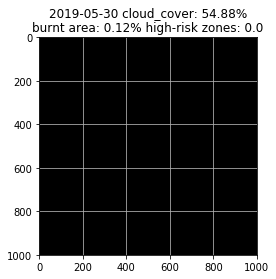

In [62]:
fig = plt.figure()

##### idx 0-35
i=-1
MAX=36

##### idx 36-71
i=35
MAX=72

#### idx 72-107
i=71
MAX=108

im = plt.imshow(risks[i,:,:,0], cmap='Greys_r', vmin=0, vmax=1, animated=True)
plt.grid(True)

thres = 0.66
title = plt.title(f"{bigquery_res_s['sensing_time'].dt.date.map(lambda t:str(t))[i+1]} cloud_cover: {bigquery_res_s['cloud_cover'][i+1].round(2)}%\n median dNBR: {dnbr_medians[i]} burnt area {(100*(labs[i,:,:,0].sum())/(1000*1000)).round(2)}%\n high-risk zones: {risks[i,:,:,0].sum()//(40000)}")

def updatefig(*args):
    
    global i
    if (i<=MAX):
        i += 1
    else:
        pass
    im.set_array(risks[i-2,:,:,0])
    #title.set_text(f"{bigquery_res_s['sensing_time'].dt.date.map(lambda t:str(t))[i-1]} cloud_cover: {bigquery_res_s['cloud_cover'][i-1].round(2)}%\nburnt area: {(100*(labs[i,:,:,0].sum())/(1000*1000)).round(2)}% high-risk zones: {risks[i-2,:,:,0].sum()//(40000)}")
    title.set_text(f"{bigquery_res_s['sensing_time'].dt.date.map(lambda t:str(t))[i-1]} cloud_cover: {bigquery_res_s['cloud_cover'][i-1].round(2)}%\nburnt area: {(100*(labs[i-2,:,:,0].sum())/(1000*1000)).round(2)}% high-risk zones: {risks[i-2,:,:,0].sum()//(40000)}")
    return im, title,

ani = animation.FuncAnimation(fig, updatefig,  blit=True, frames=109)
plt.show()


In [63]:
#ani.save('risks_anim_0.gif', fps=4, extra_args=['-vcodec', 'libx264'])   # 01/15/2018 to 10/02/2018
#ani.save('risks_anim_1.gif', fps=4, extra_args=['-vcodec', 'libx264'])   # 10/07/2018 to 06/04/2019
#ani.save('risks_anim_2.gif', fps=4, extra_args=['-vcodec', 'libx264'])   # 06/14/2019 to 01/15/2020


MovieWriter ffmpeg unavailable. Trying to use pillow instead.
